In [ ]:
# Install your library here, for example the fynesse template
# is set up to be pip installable
%pip install git+https://github.com/jeffrey-22/ads.git
import os, fynesse
# 2 min

In [1]:
# Import local fynesse module. Do NOT run this cell if the notebook is not run from the repo - this is a quick hack for local runs
%load_ext autoreload
%autoreload 2
import os, sys, IPython
from pathlib import Path
try:
    notebook_path = Path(IPython.get_ipython().run_line_magic('pwd', '')).as_posix()
except AttributeError:
    notebook_path = Path(__file__).resolve().as_posix()
script_path = os.path.abspath(notebook_path)
project_path = os.path.abspath(os.path.join(script_path, '..'))
sys.path.append(project_path)
import fynesse

d:\Projects\ads\fynesse\assess.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn)


The schema stores price transaction data about the traded households.
- ```transaction_unique_identifier``` and ```db_id``` are indices for transactions and for our database respectively.
- ```price``` describes, in GBP, the price of the household.
- ```postcode```, ```primary_addressable_object_name```, ```secondary_addressable_object_name```, ```street```, ```locality```, ```town_city```, ```district```, ```county``` describe the address. We will ultimately only use the postcode to find the latitude and longitude.
- ```property_type``` describes one of: Detached, Semi-detached, Terraced, Flat/maisonette, Other, indicated by the initials.
- ```new_build_flag```, ```tenure_type```, ```ppd_category_type```, ```record_status``` likely describe some categories, but they are not very helpful as we are ultimately not given these when predicting.

We will do some sanity checks and general visualisation of the data in the address part.

In [53]:
pp_database_conn = fynesse.access.DatabaseConnection.get_connection()

In [ ]:
# Write the code you need for creating the table, downloading and uploading the data here. You can use as many code blocks as you need.
# Warning: run these once when populating the database. No need to run them again just for prediction!
# 20 min
os.makedirs("tmp_data", exist_ok=True)
downloaded_pathnames = fynesse.access.download_price_data()
print(f"Downloaded files: {downloaded_pathnames}")
fynesse.access.create_pp_table(pp_database_conn)
# 15m
fynesse.access.upload_files_to_table(pp_database_conn, downloaded_pathnames, 'pp_data')
# 11m
fynesse.access.setup_pp_table(pp_database_conn)

In [ ]:
# Warning: run these once when populating the database. No need to run them again just for prediction!
fynesse.access.create_postcode_table(pp_database_conn)
# 10s
postcode_filename = fynesse.access.download_postcode_data()
# 1m
fynesse.access.upload_files_to_table(pp_database_conn, [postcode_filename], 'postcode_data')
# 1m
fynesse.access.setup_postcode_table(pp_database_conn)

In [ ]:
# Warning: run these once when populating the database. No need to run them again just for prediction!
fynesse.access.create_prices_coordinates_table(pp_database_conn)
# 20m
joined_table_pathnames = fynesse.access.join_all_tables(downloaded_pathnames, postcode_filename, overwrite=False)
# 10m
fynesse.access.upload_files_to_table(pp_database_conn, joined_table_pathnames, 'prices_coordinates_data', ignore_first_row=True)
# 9m
fynesse.access.setup_prices_coordinates_table(pp_database_conn)

In [ ]:
# Use this cell and cells below for summarising your analysis and documenting your decision making.

d:\Projects\ads\fynesse\assess.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn)


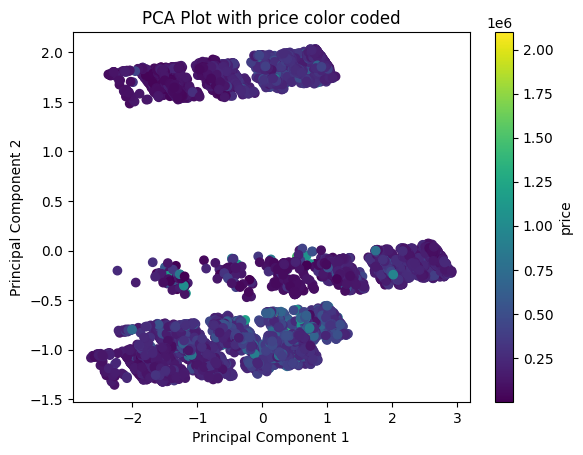

In [4]:
fynesse.assess.general_PCA_plot_with_one_column_colorcoded()

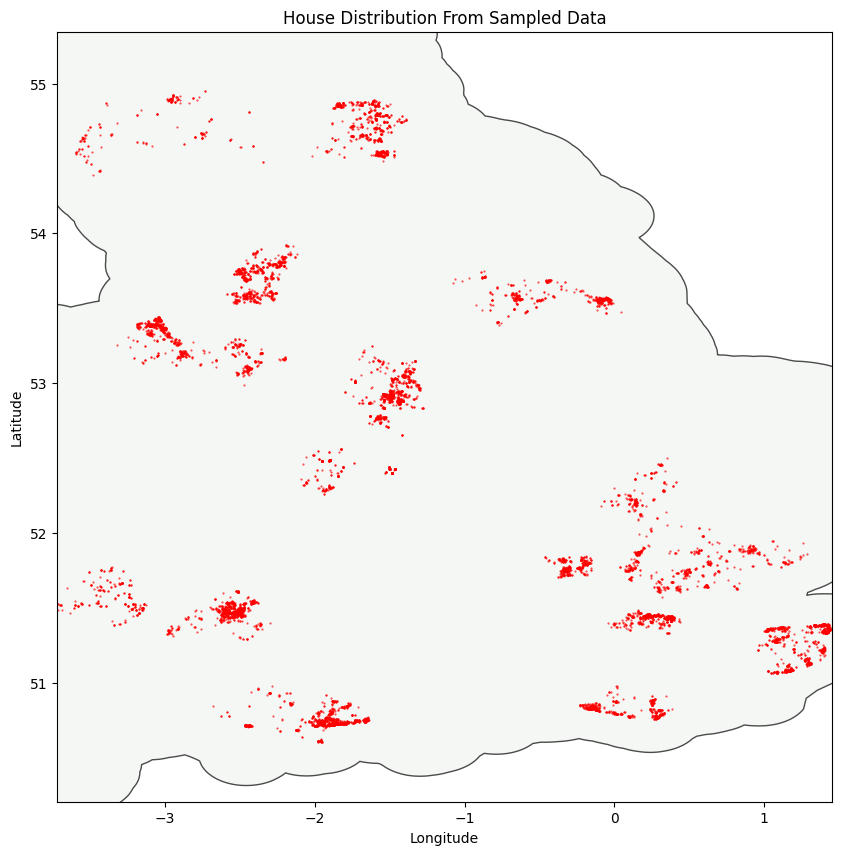

In [5]:
fynesse.assess.plot_general_house_distribution()

d:\Projects\ads\fynesse\assess.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn)


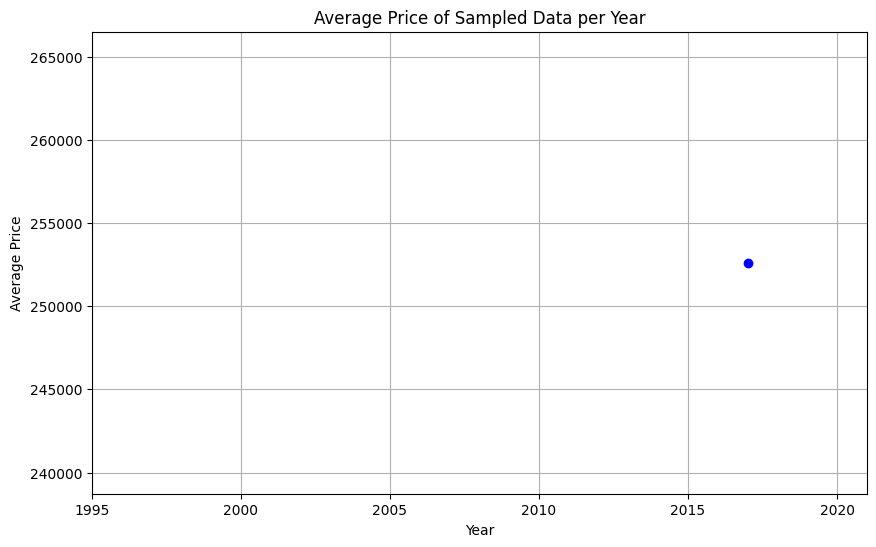

In [13]:
fynesse.assess.plot_average_house_price_against_year()

## Model decisions

The features I end up using are:
- Date, converted to number of days compared to a reference date
- Type of property, one-hot encoded
- Closest euclidean distance to: school, hospital, library, restaurant, transport, shop, leisure (if none nearby the distance is -1, which means it's just a constant column that does nothing).

Reasonings for the features I include:
- Date - the economics could be related to time, so it could also relate to the price of houses. (we end up choosing a date range to predict, but the range could still be pretty big)
- Type of property - seems like a general indication of the house quality
- Distances - I would like to use actual walking distances but that sadly takes too long. Anyhow there is kikely some correlation between that and the house quality.

Reasonings for the features I choose not to include:
- City name, street name, etc. - Sounds like cheating. Worried the prediction might need to be verbose and account for a virtual house that does not have address data yet. Also the bounding box might already account for that.
- Other house type information (that are present in the price data) - Seems like we simply do not have access to them when making predictions.

The model is a just GLM, with a link of an identity function

Reasonings for the model:
- I am not really any expert at economics, so I figured a simple model should keep my sanity.
- I would like to experiment more with different possibilities and their impact on accuracy, but the biggest constraint here is that most of them take way too much time to compute.
- One downside is that I might get negative values and such. I'd say they are probably just indication of bad predictions.
- Ultimately my "excuses" for bad results is just that the training dataset is not big and fine-tuned. But given the implementation time constraint, the computation resource limitations, and also my poor knowledge in economics, that is basically unavoidable.

d:\Projects\ads\fynesse\assess.py:196: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  


==== Validation of current model, level 6 ====
No warning issued

Details of each validation level:
Level | Message
  0   | No validation
  1   | Warnings
  2   | Summary
  3   | Help message
  4   | PCA of feature array
  5   | Stratified Cross-Validation on training dataset
  6   | Area Prediction Plot
              
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1290
Model:                            GLM   Df Residuals:                     1277
Model Family:                Gaussian   Df Model:                           12
Link Function:               Identity   Scale:                      1.3549e+12
Method:                          IRLS   Log-Likelihood:                -19842.
Date:                Sun, 26 Nov 2023   Deviance:                   1.7302e+15
Time:                        23:28:08   Pearson chi2:                 1.73e+15
No. Iterations:                     3   Pseudo 

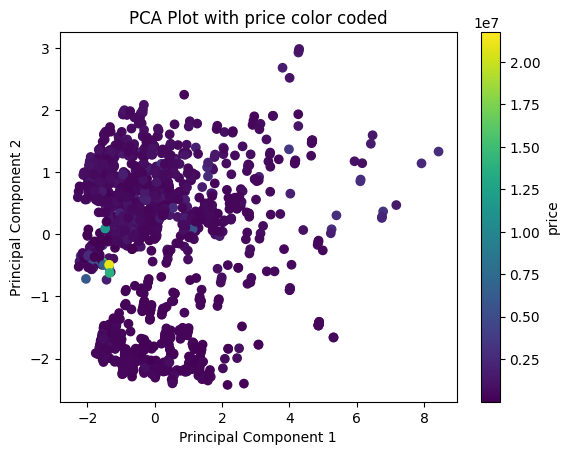

c:\Users\86189\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Stratified Cross-Validation on 5 folds result R^2: 0.13122187337748303
==== End of Validation ====


-8012992.448484223

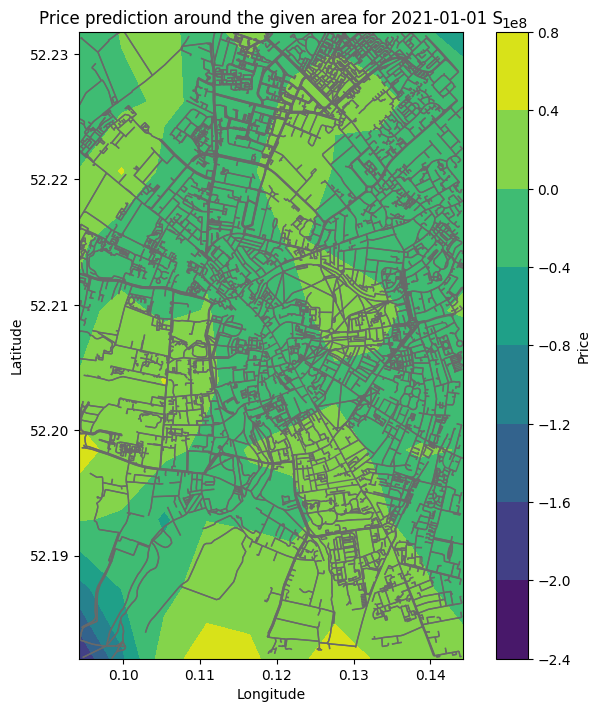

In [17]:
from datetime import date
fynesse.address.predict_price(52.206767, 0.119229, date(2021, 1, 1), 'S', validation_level=6)

d:\Projects\ads\fynesse\assess.py:196: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  


==== Validation of current model, level 6 ====
No warning issued

Details of each validation level:
Level | Message
  0   | No validation
  1   | Warnings
  2   | Summary
  3   | Help message
  4   | PCA of feature array
  5   | Stratified Cross-Validation on training dataset
  6   | Area Prediction Plot
              
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  213
Model:                            GLM   Df Residuals:                      200
Model Family:                Gaussian   Df Model:                           12
Link Function:               Identity   Scale:                      1.3863e+11
Method:                          IRLS   Log-Likelihood:                -3027.8
Date:                Sun, 26 Nov 2023   Deviance:                   2.7725e+13
Time:                        23:58:44   Pearson chi2:                 2.77e+13
No. Iterations:                     3   Pseudo 

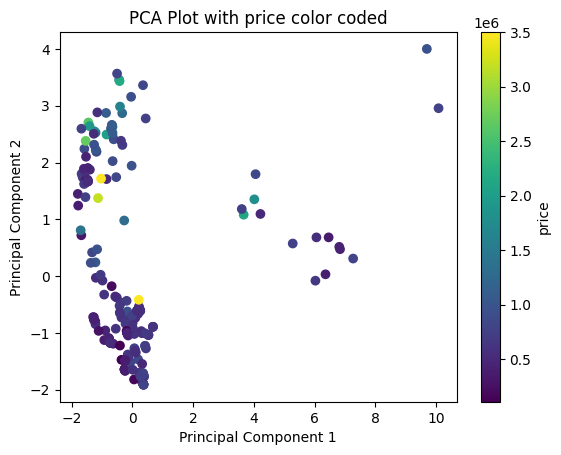

Stratified Cross-Validation on 5 folds result R^2: 0.16821662220474354


c:\Users\86189\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


==== End of Validation ====


31679681.13935606

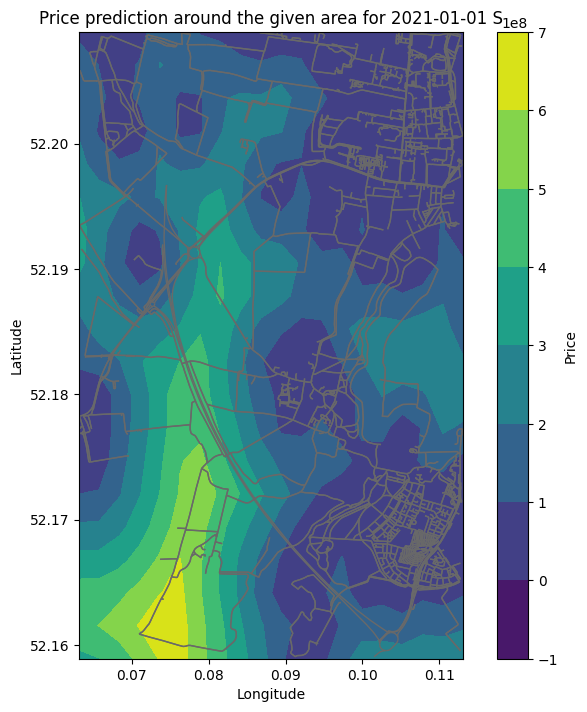

In [18]:
fynesse.address.predict_price(52.1839, 0.0881, date(2021, 1, 1), 'S', validation_level=6)

## Large Language Models

If you used LLMs to generate or fix code in this assignment (recommended), briefly summarise the process and prompts you used. What do you think of the integration of LLMs in the data science pipeline?

I used the interactive web chat as a separate tab. I collected some of my actual prompts at the end of my thoughts.

I believe LLMs could be very helpful in the pipeline. It has managed to save me quite some time in different places, for example error debugging, basic APIs, reptitive code formatting and more. I can always just shut off my brain and toss the question out, rather than thinking of what words people are going to use when having a similar problem as mine. The simpleness, convenience and swiftness are all that matters here. If there is anything easy to be improved, it is to make them generate answers even faster.

I also want to point out some cases where LLMs end up wasting my time. At the beginning I attempted to integrate LLMs into the project using API keys (as how I did for tick 1), but the AI seems to easily get confused about the context - a lot of the times when I asked a general question, say how to use ".apply", the AI tries to make an example with the dataframe I have previous feeded them, and it takes a lot of effort to correct them. I kind of hope that the default option is have the AI forget about the context and the data every time I give a prompt, so that such nuances could be avoided.

Some of my prompts:
- access pandas series by index
- series get length
- what does -q do in pytest
- how do you specify to pytest to only fnd tests in a subdirectory
- (I copy-pasted an error I got for github action)
```
ERROR: usage: pytest [options] [file_or_dir] [file_or_dir] [...]
pytest: error: unrecognized arguments: --md=/tmp/tmp.Kp9OUO7xLo
  inifile: /home/runner/work/ads/ads/pytest.ini
  rootdir: /home/runner/work/ads/ads

Error: Process completed with exit code 4

...

=====================================================================================
Markdown summaries: https://github.com/jeffrey-22/ads/actions/runs/6989395632
=====================================================================================
```
- test that no value in a df is null or infinite

- Some other questions are answered in [this reddit forum](https://www.reddit.com/r/CST_ADS/) or [this doc](https://docs.google.com/document/d/1GfDROyUW8HVs2eyxmJzKrYGRdVyUiVXzPcDfwOO8wX0/edit?usp=sharing). Feel free to also ask about anything that comes up.